# Find the optimum Rotation of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne et Jérémy Neveu
- affiliation : LAL/IN2P3/CNRS, France
- date   : May 29th 2017
- update : May 30th 2017


- The goal is to rotate the image correctly such the dispersive axis must be parallel to X.
Carefull check must be done with eye such the fit of the Y vs X line is correct without bias.
This can be done on every image. Another solution is to force the value of the rotation angle
if one is sure of it.
- So One must decide if he want one average rotation angle or one rotation angle for each image.
Not sure.
- An Hessian method used to detect filaments in maps has been adapted to detect the spectra and 
compute their rotation angles

In [4]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [5]:
print theNotebook

FindOptRot


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [7]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.2.0


In [8]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [9]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [10]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [11]:
%load_ext Cython

In [12]:
from IPython.display import Image, display

In [13]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [14]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [15]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)

In [16]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [17]:
ensure_dir(dir_top_images) # create that directory

### input directory of fits images

In [18]:
inputdir="cut_fitsimages"
MIN_IMGNUMBER=6
MAX_IMGNUMBER=10
object_name='HD111980 June 1st 2017'
SelectTagRe='^cutimg_20170601_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^cutimg_20170601_[0-9]+.fits$'
NBIMGPERROW=3

### output directory of fits images

In [19]:
outputdir="./rotated_fitsimages"

In [20]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [21]:
input_filelist=os.listdir(inputdir) 

In [22]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [23]:
print input_filelist

['cutimg_20170601_006.fits' 'cutimg_20170601_007.fits'
 'cutimg_20170601_008.fits' 'cutimg_20170601_009.fits'
 'cutimg_20170601_010.fits' 'star_centroids.txt']


In [24]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [25]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall(SelectTagRe,file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

    


In [26]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [27]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [28]:
print indexes_files

[ 6  7  8  9 10]


In [29]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [30]:
sorted_numbers=indexes_files[sorted_indexes]

In [31]:
print sorted_indexes

[0 1 2 3 4]


In [32]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [33]:
#sorted_files

## Build full filename
----------------------------

In [34]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [35]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [36]:
print sorted_filenames.shape

(5,)


## Acces to data of  images
----------------------------------

In [37]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt = []

In [38]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_expo = []
    all_filt = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        filters = header['FILTERS']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt

In [39]:
all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [40]:
len(all_images)

5

In [41]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

global NBIMGPERROW
    
def ShowImages(all_images,all_titles,object_name,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=4
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,3*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        xprofile=np.sum(all_images[index],axis=0)
        x0=np.where(xprofile==xprofile.max())[0][0]
        thex0.append(x0)
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=-10,vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
    title='Images of {}'.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)  
    return thex0

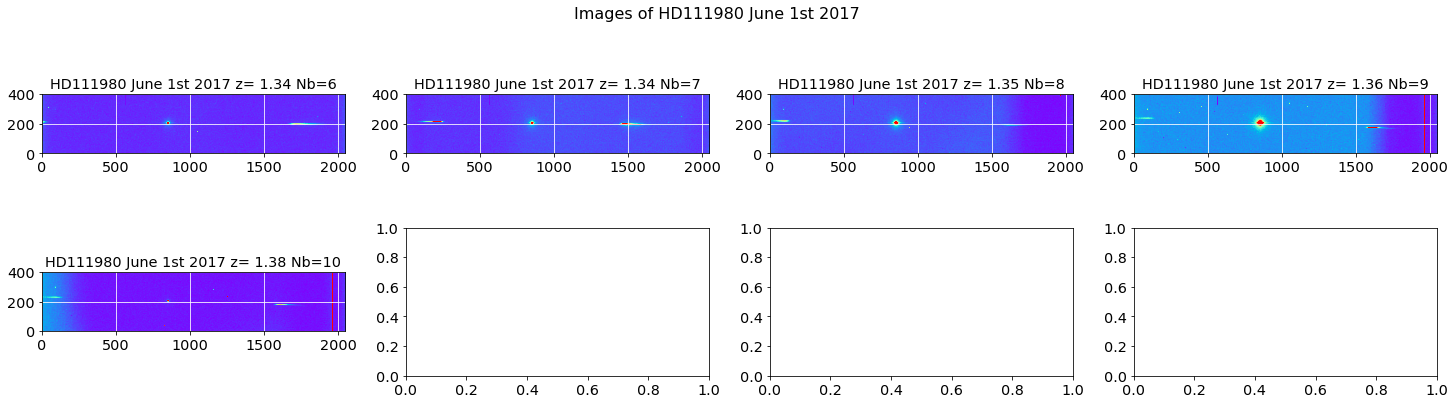

In [42]:
thex0=ShowImages(all_images,all_titles,object_name,dir_top_images)

## Duplicate the images

In [43]:
all_images2=[]
for image in all_images:
    image_copy=np.copy(image)
    all_images2.append(image_copy)


## Subtract Background

In [44]:
for theimage in all_images2:
    NR,NC=theimage.shape
    EmptySkyBackground=np.zeros([NR,NC])
    SkyBackground=EmptySkyBackground+np.median(theimage,axis=0)
    theimage-=SkyBackground

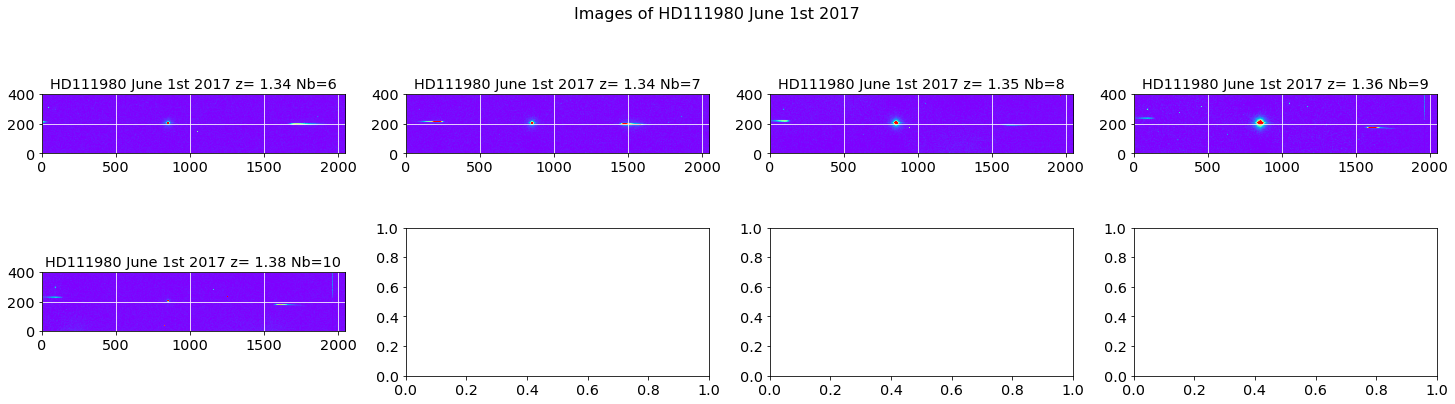

In [45]:
thex02=ShowImages(all_images2,all_titles,object_name,dir_top_images)

### Shows the transverse profile

In [46]:
DeltaX=600
w=20
ws=80

In [47]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
    
import os


def ShowTransverseProfile(all_images,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowTransverseProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=4
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    DeltaX=600
    w=20
    ws=80
    thespectra= []
    they0= []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        data=np.copy(all_images[index])
        data[:,DeltaX-ws:DeltaX+ws]=0
        if(all_expo[index]<=0):
            yprofile=np.sum(data,axis=1)  #very special case
        else:
            yprofile=np.sum(data,axis=1)/all_expo[index]
        ymin=1
        ymax=yprofile.max()
        y0=np.where(yprofile==ymax)[0][0]
        they0.append(y0)
        #im=axarr[iy,ix].imshow(data,vmin=-10,vmax=50)
        axarr[iy,ix].semilogy(yprofile)
        axarr[iy,ix].semilogy([y0,y0],[ymin,ymax],'r-')
        axarr[iy,ix].semilogy([y0-w,y0-w],[ymin,ymax],'k-')
        axarr[iy,ix].semilogy([y0+w,y0+w],[ymin,ymax],'k-')
        axarr[iy,ix].set_ylim(1000.,2e5)
        spectrum2D=np.copy(data[y0-w:y0+w,:])
        xprofile=np.sum(spectrum2D,axis=0)
        thespectra.append(xprofile/(2.*float(w))/all_expo[index])
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
    title='Spectrum tranverse profile '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'transverse_profile.pdf')
    plt.savefig(figfilename)  
    return thespectra,they0

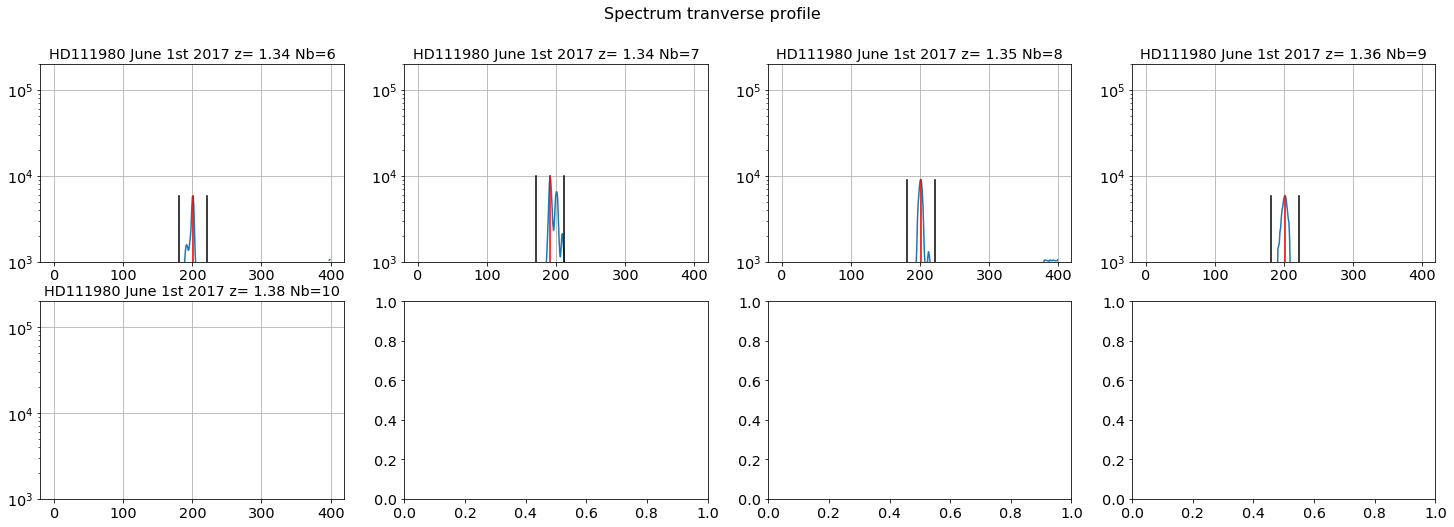

In [48]:
thespectra,they0=ShowTransverseProfile(all_images2,all_titles,object_name,all_expo,dir_top_images)

In [49]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
def ShowSpectrumProfile(spectra,all_titles,object_name,dir_top_images):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=4
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index])
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,200.)
    title='Spectrum 1D profile '.format(object_name)
    figfilename=os.path.join(dir_top_images,'longitudinal_profile.pdf')
    plt.savefig(figfilename)  
    plt.suptitle(title,size=16)

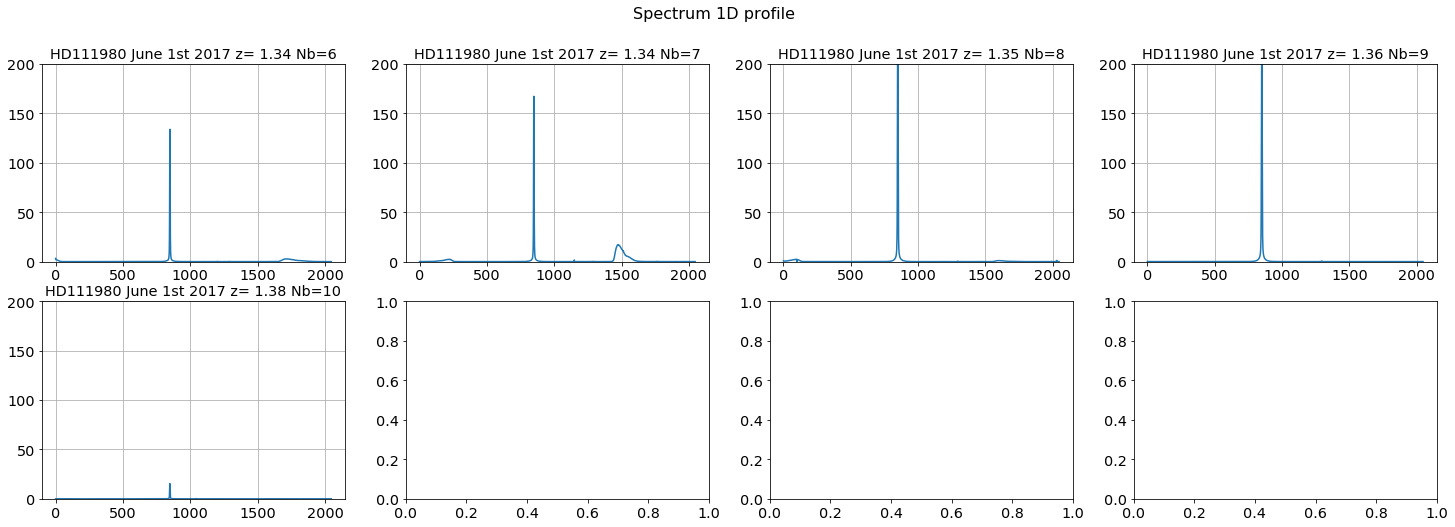

In [50]:
ShowSpectrumProfile(thespectra,all_titles,object_name,dir_top_images)

In [51]:
print they0

[201, 191, 201, 201, 201]


In [52]:
print thex0

[849, 849, 1958, 1958, 1958]


### Test rotation optimum
----------------------------

In [53]:
from scipy import stats 
from scipy import ndimage
from scipy.optimize import curve_fit

In [54]:
sel=4

In [55]:
image_sel=np.copy(all_images2[sel])
y0=they0[sel]
x0=thex0[sel]

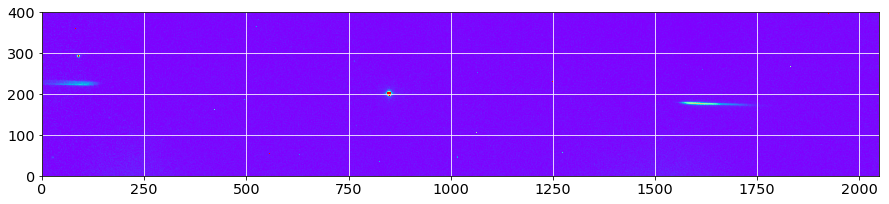

In [56]:
plt.imshow(image_sel,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')

In [57]:
region=np.copy(image_sel[y0-100:y0+100,:])
data=np.copy(region)

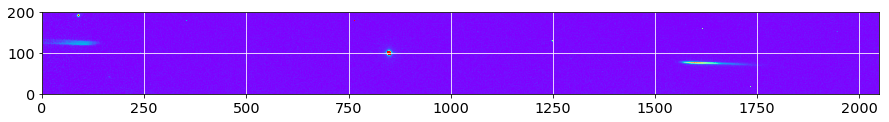

In [58]:
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')

### find the orientation by the average

In [59]:
def ComputeMedY(data):
    """
    Compute the median of Y vs X to find later the angle of rotation
    """
    NBINSY=data.shape[0]
    NBINSX=data.shape[1]
    the_medianY=np.zeros(NBINSX)
    the_y=np.zeros(NBINSY)
    for ix in np.arange(NBINSX):
        the_ysum=np.sum(data[:,ix])
        for iy in np.arange(NBINSY):
            the_y[iy]=iy*data[iy,ix]
        if(the_ysum>0):
            med=np.sum(the_y)/the_ysum
            the_medianY[ix]=med
    return the_medianY

In [60]:
def ComputeAveY(data):
    """
    Compute the average of Y vs X to find later the angle of rotation
    """
    NBINSY=data.shape[0]
    NBINSX=data.shape[1]
    the_averY=np.zeros(NBINSX)
    the_y=np.zeros(NBINSY)
    for ix in np.arange(NBINSX):
        the_ysum=np.sum(data[:,ix])
        for iy in np.arange(NBINSY):
            the_y[iy]=iy*data[iy,ix]
        if(the_ysum>0):
            med=np.sum(the_y)/the_ysum
            the_averY[ix]=med
    return the_averY

In [61]:

xindex=np.arange(data.shape[1])

In [62]:
#selected_indexes=np.where(np.logical_or(xindex<480,xindex>1100))

In [63]:
#selected_indexes=np.where(np.logical_or(np.logical_and(xindex>100,xindex<200) ,np.logical_and(xindex>1410,xindex<1600)))

In [64]:
selected_indexes=np.where(np.logical_or(np.logical_and(xindex>0,xindex<200) ,np.logical_and(xindex>750,xindex<1600)))

In [65]:
yaver=ComputeAveY(data)

In [66]:
XtoFit=np.array(xindex[selected_indexes])
YtoFit=np.array(yaver[selected_indexes])

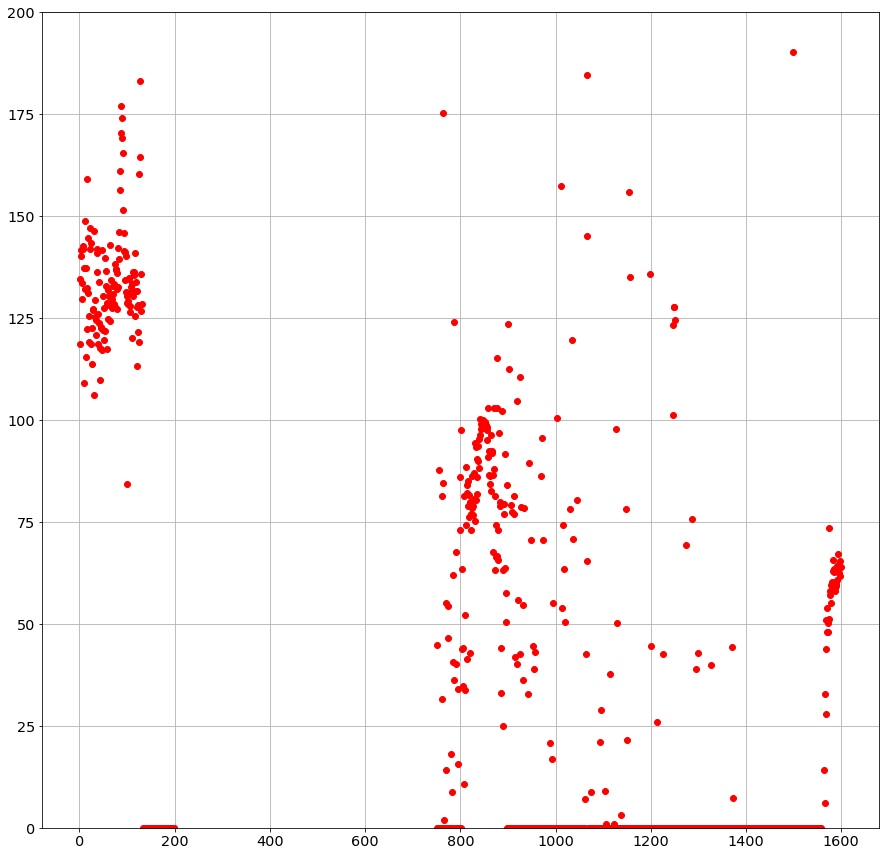

In [67]:
plt.plot(XtoFit,YtoFit,'ro')
plt.ylim(0,200)
plt.grid(True)

In [68]:
selected_indexes2=np.where(np.logical_and(YtoFit<200,YtoFit>0))

In [69]:
XtoFit2=XtoFit[selected_indexes2]
YtoFit2=YtoFit[selected_indexes2]

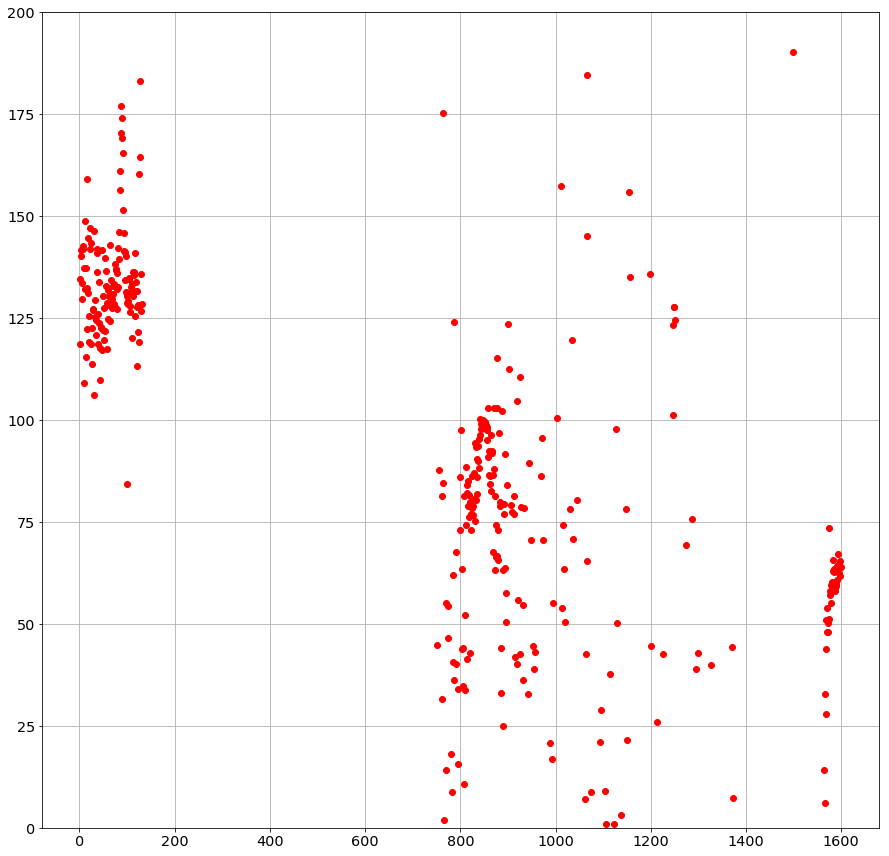

In [70]:
plt.plot(XtoFit2,YtoFit2,'ro')
plt.ylim(0,200)
plt.grid(True)

In [71]:
def fit_func(x, a, b):
    return a*x + b

In [72]:
from scipy.optimize import curve_fit
   

In [73]:
params = curve_fit(fit_func, XtoFit2, YtoFit2)
[a, b] = params[0]

In [74]:
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = fit_func(x_new,a,b)

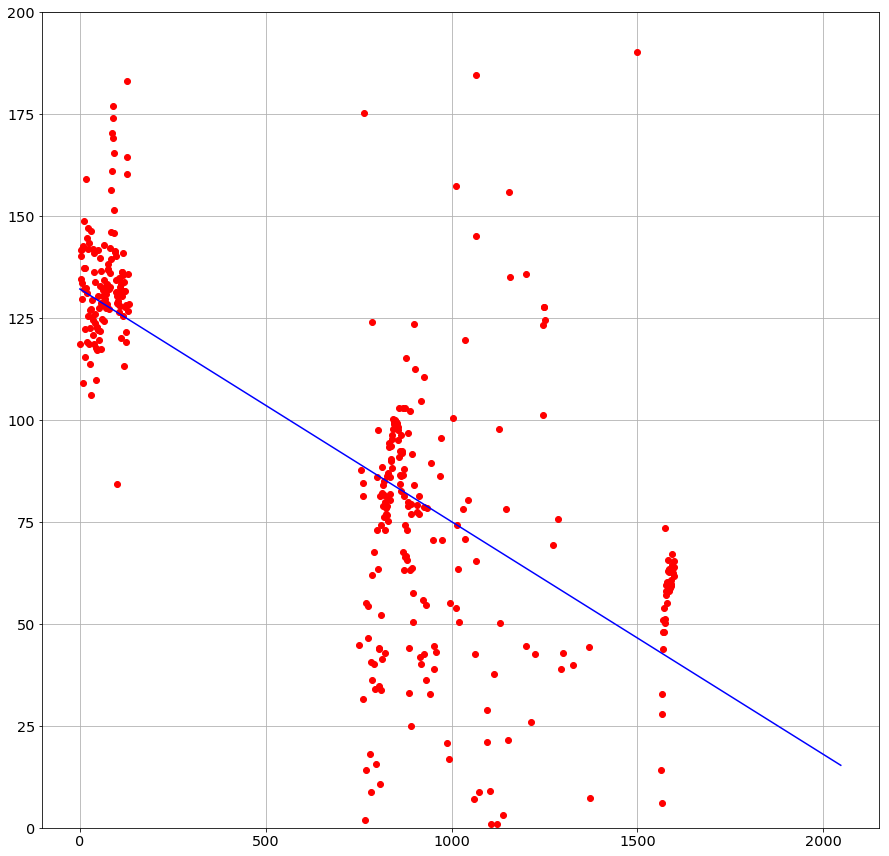

In [75]:
plt.plot(XtoFit2,YtoFit2,'ro')
plt.plot(x_new,y_new,'b-')
plt.ylim(0,200)
plt.grid(True)

In [76]:
print a,b

-0.0570694912713 132.154070884


In [77]:
print np.arctan(a)*180/np.pi

-3.2662980321


### Find rotation by Hessian analysis

La méthode s'inspire des techniques de détection de filmanents dans le milieu interstellaire.
Elle est décrite dans https://arxiv.org/pdf/1409.6728.pdf section 4.1.
Documentation sur le calcul du Hessien : http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hessian_matrix

In [78]:
from skimage.feature import hessian_matrix
# le paramètre sigma permet de lisser le hessien
Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
print lambda_minus

[[ -8.65496690e-03  -9.51639942e-03  -1.57513014e-02 ...,   1.06690556e-02
    1.51992230e-02   1.54094571e-02]
 [ -4.83614921e-03  -3.38094210e-03  -8.48875977e-03 ...,   1.85782367e-02
    2.36647264e-02   2.16137560e-02]
 [  2.18281993e-03   5.79355480e-03   1.06602883e-03 ...,   2.07158288e-02
    3.13266563e-02   2.29965442e-02]
 ..., 
 [ -4.30682058e-02  -6.78877346e-02  -1.05044788e-01 ...,  -1.35101920e-02
   -5.83904636e-03  -1.36809294e-04]
 [ -3.91456017e-02  -6.48156670e-02  -1.06888784e-01 ...,  -6.30163294e-03
    2.20504463e-03   5.46965733e-03]
 [ -3.63649450e-02  -5.95133993e-02  -1.03412703e-01 ...,  -8.03692548e-03
    7.01808952e-05   2.32908709e-03]]


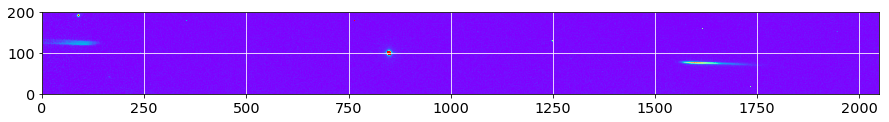

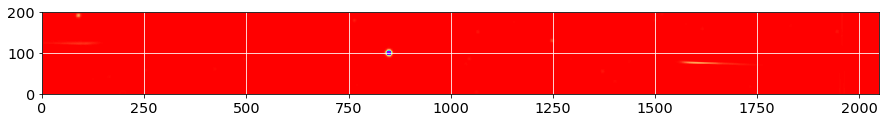

In [79]:
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()
plt.imshow(lambda_minus,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='white', ls='solid')
plt.show()

Maintenant on va sélectionner le spectre à l'aide d'un seuil pour éliminer le fond.

Number of remaining pixels : 1524


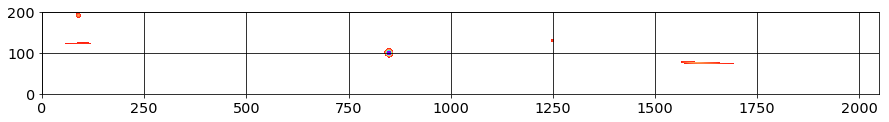

In [80]:
threshold = -4
mask = np.where(lambda_minus>threshold)
lambda_mask = np.copy(lambda_minus)
lambda_mask[mask]=np.nan
print 'Number of remaining pixels :',len(lambda_mask[~np.isnan(lambda_mask)])
plt.imshow(lambda_mask,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='black', ls='solid')
plt.show()

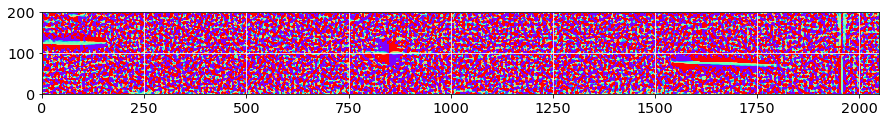

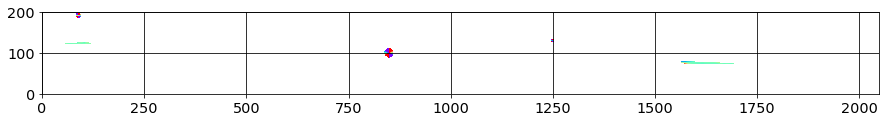

In [81]:
theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi
plt.imshow(theta,origin='lower',cmap='rainbow',vmin=-30,vmax=30)
plt.grid(color='white', ls='solid')
plt.show()
theta_mask = np.copy(theta)
theta_mask[mask]=np.nan
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-30,vmax=30)
plt.grid(color='black', ls='solid')
plt.show()

On sait que l'angle que l'on recherche est petit car l'axe de dispersion du réseau est bien aligné selon x, donc on peut sélectionner.

Number of remaining pixels : 1016


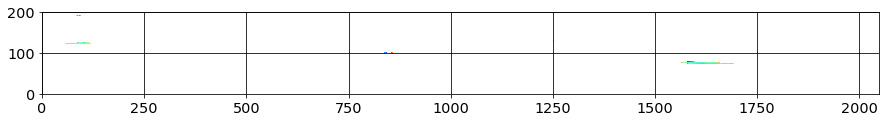

In [82]:
deg_threshold = 12
mask2 = np.where(np.abs(theta)>deg_threshold)
theta_mask[mask2] = np.nan
print 'Number of remaining pixels :',len(theta_mask[~np.isnan(theta_mask)])
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
plt.grid(color='black', ls='solid')
plt.show()

Angle median : -1.57620641553


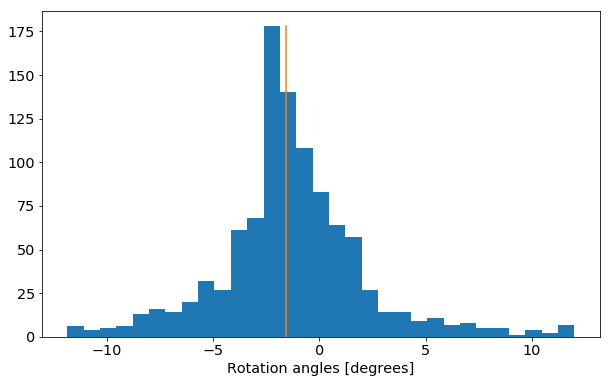

In [83]:
theta_hist = []
theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
theta_median = np.median(theta_hist)
print 'Angle median :',theta_median
fig = plt.figure(figsize=(10,6))
n,bins, patches = plt.hist(theta_hist,bins=int(np.sqrt(len(theta_hist))))
plt.plot([theta_median,theta_median],[0,np.max(n)])
plt.xlabel("Rotation angles [degrees]")
plt.show()

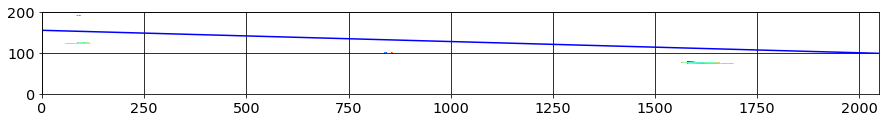

In [84]:
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = y0 -100 + (x_new-x0)*np.tan(theta_median*np.pi/180.)
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()

On peut aussi essayer de fitter le spectre qui a été détecté par la méthode ci-dessus.

Rotation angle from fit : -1.96993367479


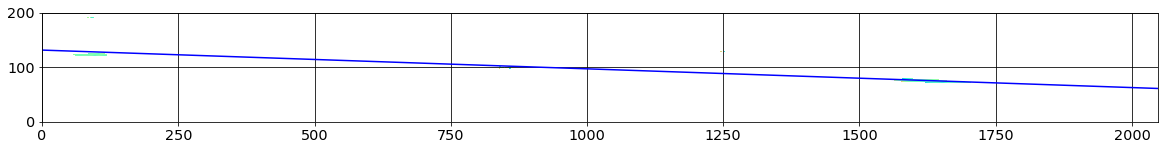

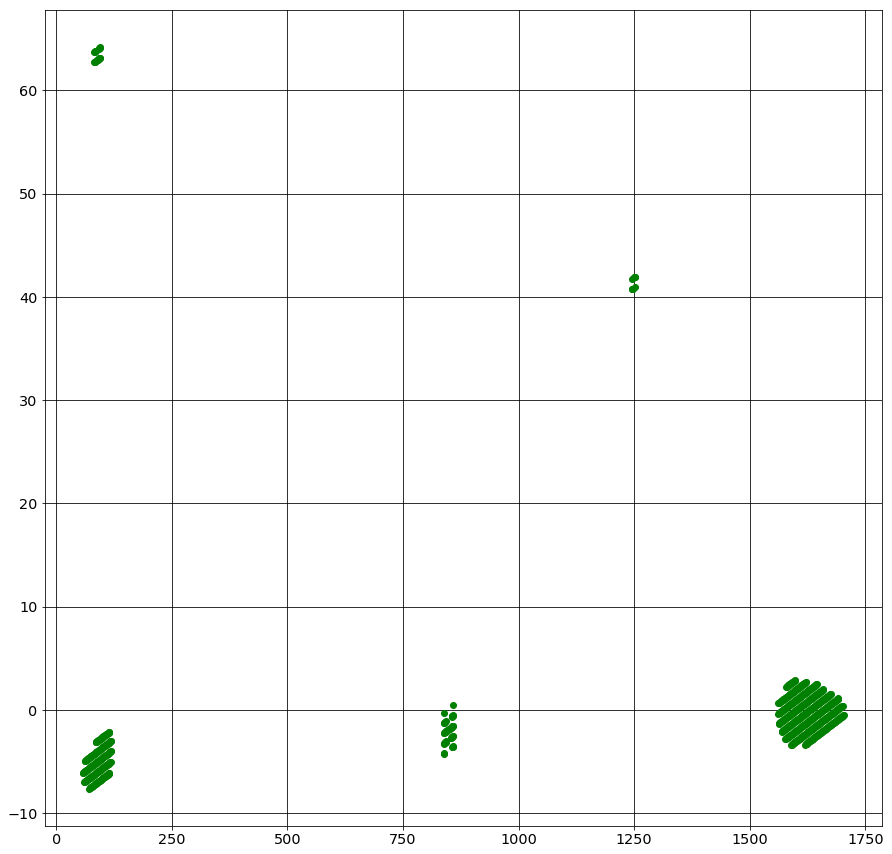

In [85]:
xtofit=[]
ytofit=[]
for iy,y in enumerate(theta_mask):
    for ix,x in enumerate(y):
        if not np.isnan(theta_mask[iy][ix]) :
            if np.abs(theta_mask[iy][ix])>12 : continue
            xtofit.append(ix)
            ytofit.append(iy)
params = curve_fit(fit_func, xtofit, ytofit)
[a, b] = params[0]
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = fit_func(x_new,a,b)
print 'Rotation angle from fit :',np.arctan(a)*180/np.pi
fig = plt.figure(figsize=[20,30])
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-30,vmax=30)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()
diff = []
for ix,x in enumerate(xtofit):
    diff.append(ytofit[ix]-fit_func(x,a,b))
plt.plot(xtofit,diff,'go')
plt.grid(color='black', ls='solid')
plt.show()

Je pense que la méthode de fit est plus compliquée dans un champ encombré.

## Find Rotation angle for each image
----------------------------------------------

In [86]:
def ComputeRotationAngle(all_images,thex0,they0,all_titles,object_name):
    """
    ComputeRotationAngle
    ====================
    
    input:
    ------
    all_images
    thex0
    they0
    
    
    output:
    ------
    param_a
    param_b
    
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    param_a=np.zeros(NBIMAGES)
    param_b=np.zeros(NBIMAGES)

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        image=all_images[index]    
        
        image_sel=np.copy(image)
        y0=they0[index]
        x0=thex0[index]
        
        # extract a region of 200 x 1000 centered at y=100,x=500
        
        region=np.copy(image_sel[y0-100:y0+100,:])
        data=np.copy(region)
        
        xindex=np.arange(data.shape[1])
        
        #selected_indexes=np.where(np.logical_or(np.logical_and(xindex>100,xindex<200) ,np.logical_and(xindex>1410,xindex<1600))) 
        selected_indexes=np.where(np.logical_or(np.logical_and(xindex>0,xindex<150) ,np.logical_and(xindex>1500,xindex<1600)))
        # compute Y vs X
        yaver=ComputeAveY(data)
        
        XtoFit=xindex[selected_indexes]
        YtoFit=yaver[selected_indexes]
        # does the fit
        params = curve_fit(fit_func, XtoFit, YtoFit)
        [a, b] = params[0]
        
        param_a[index]=a
        param_b[index]=b
        
        print index,' y = ',a,' * x + ',b
        x_new = np.linspace(xindex.min(),xindex.max(), 50)
        y_new = fit_func(x_new,a,b)
    
        im=axarr[iy,ix].plot(XtoFit,YtoFit,'ro')
        im=axarr[iy,ix].plot(x_new,y_new,'b-')
        axarr[iy,ix].set_title(all_titles[index])
        
        axarr[iy,ix].set_ylim(0,200)
        axarr[iy,ix].grid(True)
        
    title='Fit rotation angle of '.format(object_name)    
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
    plt.savefig(figfilename)  
    
    
    return param_a,param_b
    
    

0  y =  -0.0284696090866  * x +  88.5049574763
1  y =  -0.00306490126004  * x +  105.115234637
2  y =  -0.0658653708528  * x +  130.040906678
3  y =  -0.0737608983697  * x +  139.549598743
4  y =  -0.0830219149217  * x +  129.943299269


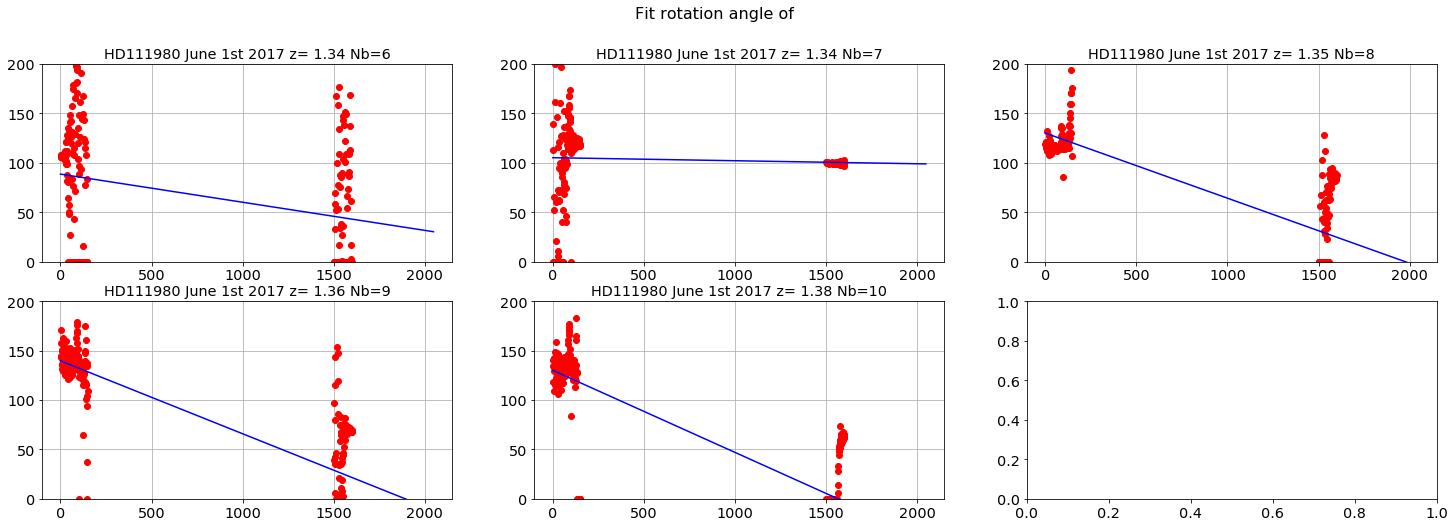

In [87]:
all_a,all_b=ComputeRotationAngle(all_images2,thex0,they0,all_titles,object_name)

In [88]:
all_angles=np.arctan(all_a)*180./np.pi

In [89]:
textfilename = os.path.join(inputdir,'star_centroids.txt')
central_positions = np.loadtxt(textfilename)

def ComputeRotationAngleHessian(all_images,thex0,they0,all_titles,object_name):
    """
    ComputeRotationAngle
    ====================
    
    input:
    ------
    all_images
    thex0
    they0
    
    
    output:
    ------
    param_a
    param_b
    
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    param_theta=np.zeros(NBIMAGES)
    
    lambda_threshold = -5
    deg_threshold = 12

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        image=all_images[index]    
        
        image_sel=np.copy(image)
        y0=they0[index]
        x0=thex0[index]
        
        # extract a region of 200 x 1000 centered at y=100,x=500
        
        region=np.copy(image_sel[y0-100:y0+100,:])
        data=np.copy(region)
        
        # compute hessian matrices on the image
        
        Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
        lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
        lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
                

        mask = np.where(lambda_minus>lambda_threshold)
        #lambda_mask = np.copy(lambda_minus)
        #lambda_mask[mask]=np.nan

        theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi
        theta_mask = np.copy(theta)
        theta_mask[mask]=np.nan

        mask2 = np.where(np.abs(theta)>deg_threshold)
        theta_mask[mask2] = np.nan
        
        theta_hist = []
        theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
        theta_median = np.median(theta_hist)
        
        param_theta[index] = theta_median
        
        print index,' theta = ',theta_median, '\tx0 = ',central_positions[index][1], '\ty0 = ',central_positions[index][0]
        x_new = np.linspace(xindex.min(),xindex.max(), 50)
        y_new = y0 -100 + (x_new-x0)*np.tan(theta_median*np.pi/180.)
    
        im=axarr[iy,ix].imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
        im=axarr[iy,ix].plot(x_new,y_new,'b-')
        axarr[iy,ix].set_title(all_titles[index])
        
        axarr[iy,ix].set_ylim(0,200)
        axarr[iy,ix].grid(True)
        

    title='Fit rotation angle of '.format(object_name)    
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
    plt.savefig(figfilename)  
    
    
    return param_theta
    

[-1.63074796 -0.17560536 -3.76836469 -4.21854866 -4.74592133]
0  theta =  -0.897636995917 	x0 =  848.0 	y0 =  537.0
1  theta =  -0.681921124014 	x0 =  848.0 	y0 =  539.0
2  theta =  -0.857774189034 	x0 =  848.0 	y0 =  537.0
3  theta =  -2.178558379 	x0 =  849.0 	y0 =  537.0
4  theta =  -1.67513759562 	x0 =  848.0 	y0 =  537.0


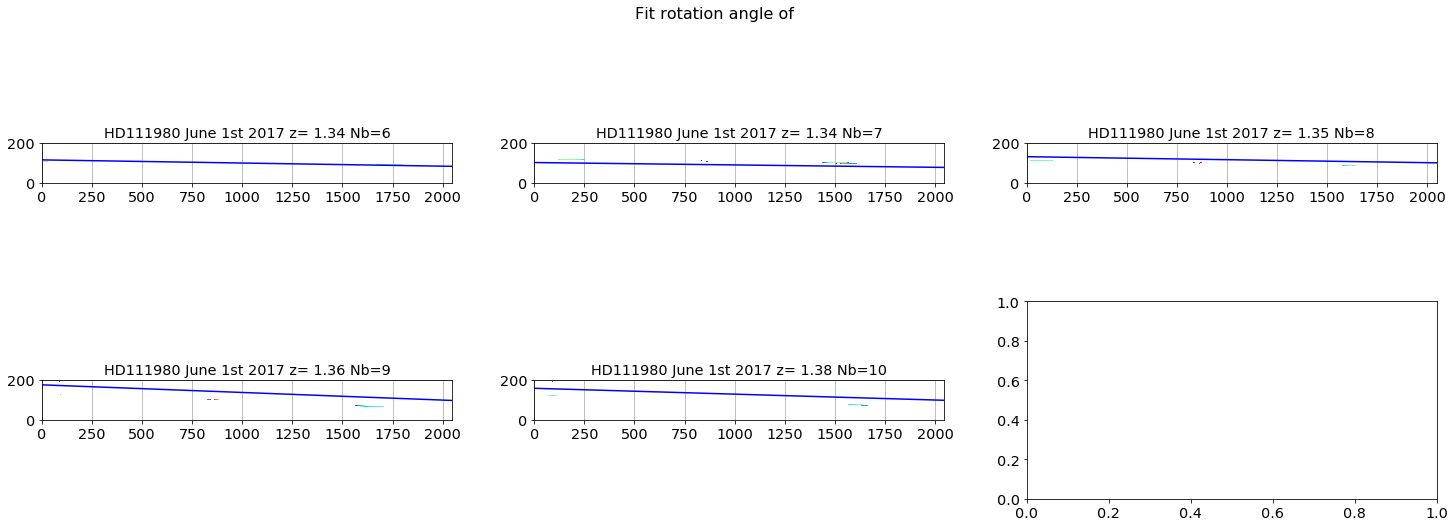

In [90]:
print all_angles
all_theta=ComputeRotationAngleHessian(all_images2,thex0,they0,all_titles,object_name)

### Choose here which rotation angle to apply

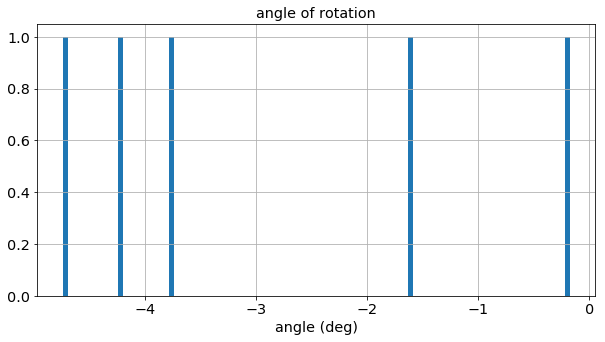

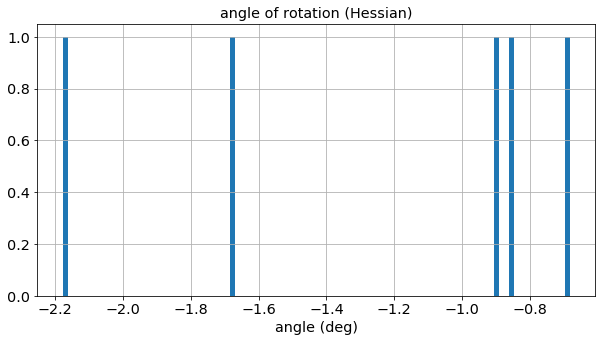

In [91]:
plt.figure(figsize=(10,5))
#hist(x, bins=10, range=None, normed=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, hold=None, data=None, **kwargs)
#n, bins, patches=plt.hist(all_angles,bins=50,range=[-1,.5],histtype='stepfilled')
n, bins, patches=plt.hist(all_angles,bins=100,histtype='stepfilled')
plt.grid(True)
plt.title('angle of rotation')
plt.xlabel('angle (deg)')
plt.figure(figsize=(10,5))
#hist(x, bins=10, range=None, normed=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, hold=None, data=None, **kwargs)
#n, bins, patches=plt.hist(all_angles,bins=50,range=[-1,.5],histtype='stepfilled')
n, bins, patches=plt.hist(all_theta,bins=100,histtype='stepfilled')
plt.grid(True)
plt.title('angle of rotation (Hessian)')
plt.xlabel('angle (deg)')

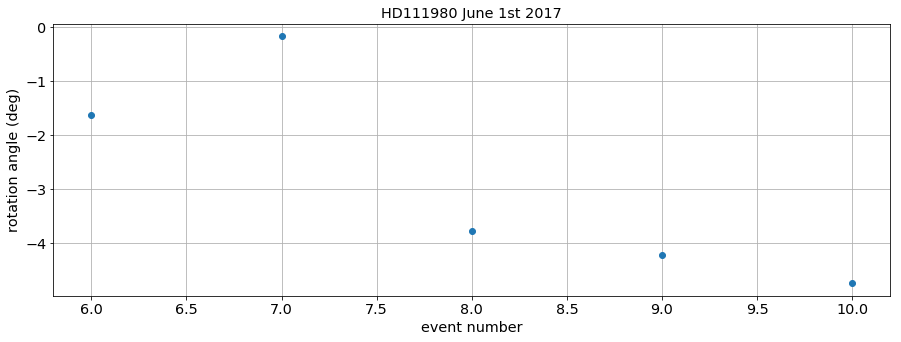

In [92]:
plt.figure(figsize=(15,5))
plt.plot(indexes_files,all_angles,'o')
plt.grid(True)
plt.ylabel('rotation angle (deg)')
plt.xlabel('event number')
plt.title(object_name)
figfilename=os.path.join(dir_top_images,'rotationvsevnum.pdf')
plt.savefig(figfilename) 

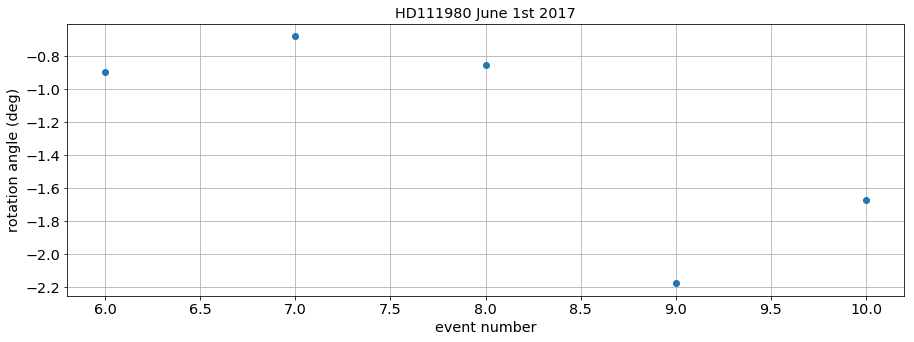

In [93]:
plt.figure(figsize=(15,5))
plt.plot(indexes_files,all_theta,'o')
plt.grid(True)
plt.ylabel('rotation angle (deg)')
plt.xlabel('event number')
plt.title(object_name)
figfilename=os.path.join(dir_top_images,'rotationvsevnum_hessian.pdf')
plt.savefig(figfilename) 

Avec la méthode Hessienne, on voit qu'on obtient des séries de 5 points : une première qui monte, une deuxième plate (donc la bonne hauteur de l'image en y ?) et trois descendantes.

## Now turn the images accordingly

In [94]:
def TurnTheImages(all_images,all_angles,all_titles,object_name,dir_top_images):
    """
    TurnTheImages
    =============
    
    input:
    ------
    all_images:
    all_angles:
    
    
    output:
    ------
    all_rotated_images
    
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    all_rotated_images = []

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        image=all_images[index]    
        angle=all_angles[index]    
        data=np.copy(image)
        
        rotated_image=ndimage.interpolation.rotate(data,angle)
        
        all_rotated_images.append(rotated_image)
        
        im=axarr[iy,ix].imshow(rotated_image,origin='lower',cmap='rainbow',vmin=0,vmax=800)
        im=axarr[iy,ix].plot(x_new,y_new,'b-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        
        axarr[iy,ix].grid(True)
        
    title='Rotated images for '.format(object_name)    
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'rotated_images.pdf')
    plt.savefig(figfilename)  
    
    return all_rotated_images

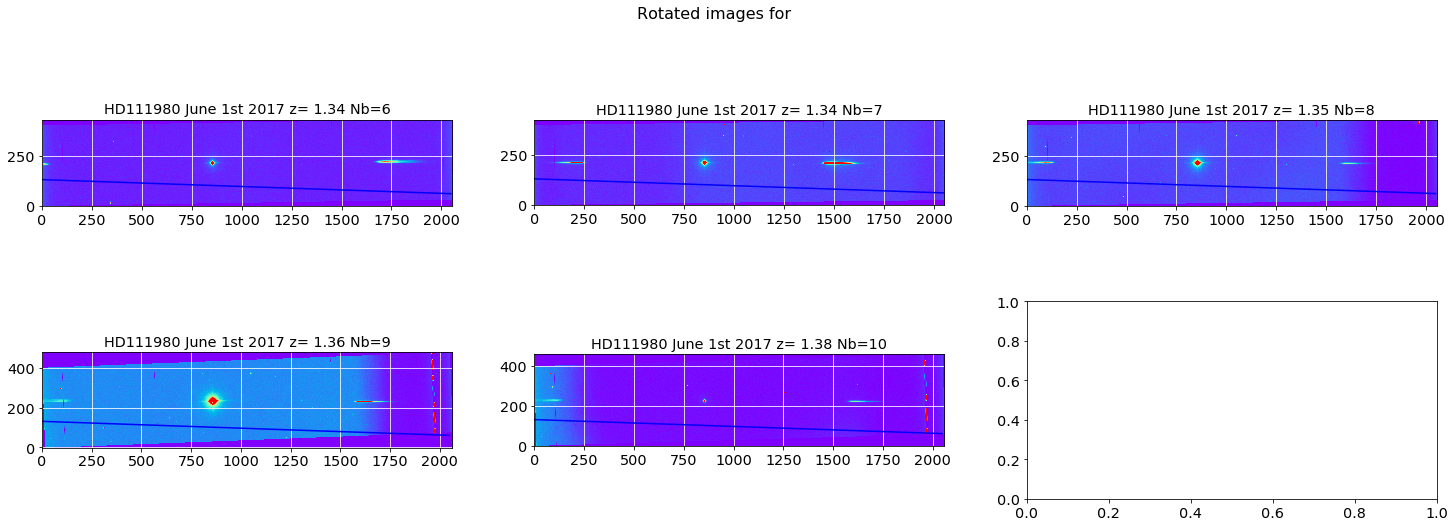

In [95]:
# J'utilise les angles qui viennent de la méthode Hessienne ici
turned_images=TurnTheImages(all_images,all_theta,all_titles,object_name,dir_top_images) #same rotation for each image

## Check rotation

In case of bad rotation, check by eye

In [96]:
sel=4

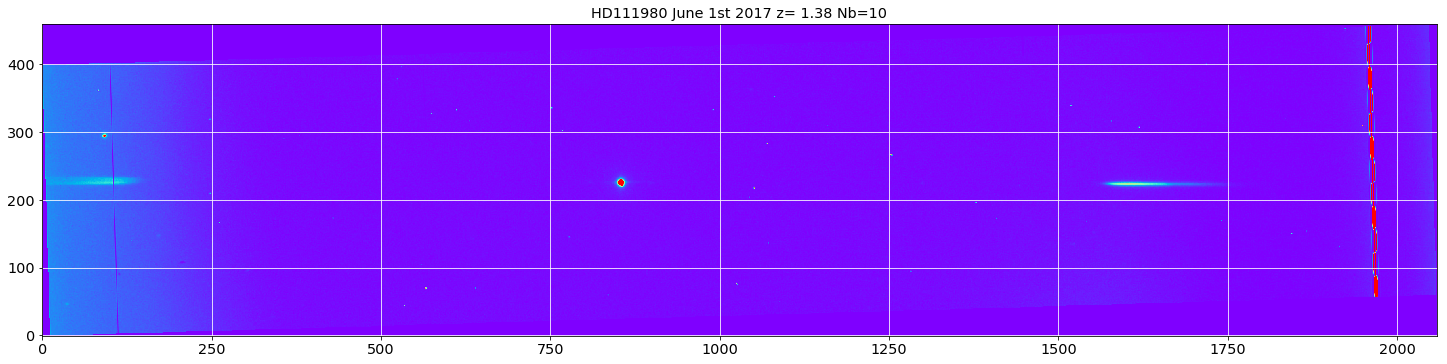

In [97]:
plt.figure(figsize=(25,10))
plt.imshow(turned_images[sel],origin='lower',cmap='rainbow',vmin=0,vmax=1000)
plt.grid(True)
plt.title(all_titles[sel])
plt.grid(color='white', ls='solid')
figfilename=os.path.join(dir_top_images,'rotated_image_sample.pdf')
plt.savefig(figfilename)  

In [98]:
image_sel=np.copy(turned_images[sel])
y0=they0[sel]
x0=thex0[sel]

In [99]:
region=np.copy(image_sel[y0-100:y0+100,:])
data=np.copy(region)

0  theta =  -0.0515566092543 	x0 =  848.0 	y0 =  537.0
1  theta =  -0.0595700098435 	x0 =  848.0 	y0 =  539.0
2  theta =  -0.115557025552 	x0 =  848.0 	y0 =  537.0
3  theta =  -0.0646028640239 	x0 =  849.0 	y0 =  537.0
4  theta =  0.0322456194246 	x0 =  848.0 	y0 =  537.0


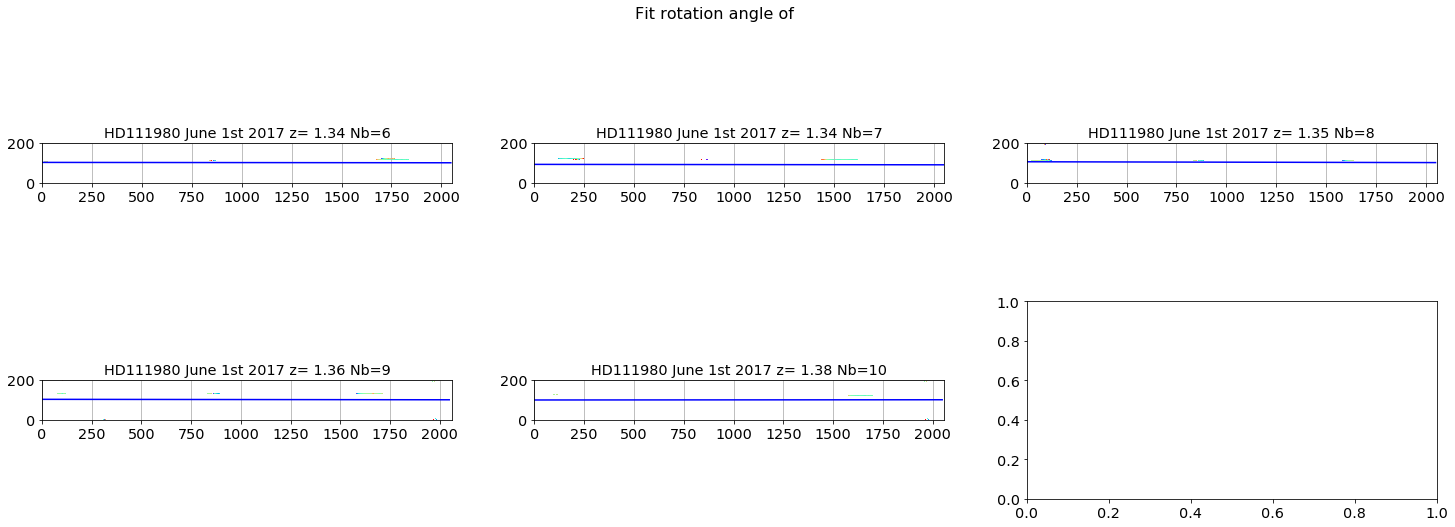

In [100]:
theta = ComputeRotationAngleHessian(turned_images,thex0,they0,all_titles,object_name)

### prepare outputfilename

In [101]:
sorted_files

array(['cut_fitsimages/cutimg_20170601_006.fits',
       'cut_fitsimages/cutimg_20170601_007.fits',
       'cut_fitsimages/cutimg_20170601_008.fits',
       'cut_fitsimages/cutimg_20170601_009.fits',
       'cut_fitsimages/cutimg_20170601_010.fits'], 
      dtype='|S39')

In [102]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[1]
    short_partfilename=re.findall('^cutimg_(.*)',short_infilename)
    short_outfilename='rotimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [103]:
newfullfilenames

['./rotated_fitsimages/rotimg_20170601_006.fits',
 './rotated_fitsimages/rotimg_20170601_007.fits',
 './rotated_fitsimages/rotimg_20170601_008.fits',
 './rotated_fitsimages/rotimg_20170601_009.fits',
 './rotated_fitsimages/rotimg_20170601_010.fits']

### Save outputfilename

In [104]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=turned_images[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

In [105]:
!ls -l rotated_fitsimages

total 71632
-rw-r--r--  1 jneveu  staff  7110720  2 jui 07:26 rotimg_20170601_006.fits
-rw-r--r--  1 jneveu  staff  6975360  2 jui 07:26 rotimg_20170601_007.fits
-rw-r--r--  1 jneveu  staff  7096320  2 jui 07:26 rotimg_20170601_008.fits
-rw-r--r--  1 jneveu  staff  7896960  2 jui 07:26 rotimg_20170601_009.fits
-rw-r--r--  1 jneveu  staff  7588800  2 jui 07:26 rotimg_20170601_010.fits
